<a href="https://colab.research.google.com/github/Gatuha/possible-loan-default-risk-flag/blob/main/possible_loan_default_risk_flag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders -q # This line installs the category_encoders library.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
sns.set_theme(style = "darkgrid")

init_notebook_mode(connected=True)
%matplotlib inline

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.9 MB/s eta 0:00:00


# Steps

1. Understanding the Data
2. Preprocess + EDA + Feature Selection
3. Extract input and output cols
4. Scale the values
5. Train test split
6. Train the model
7. Evaluate the model/model selection
8. Tuning the model
9. Deploy the model

# Understanding the Data
### You need to answer some of the questions regarding your data:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/Loan Default Risk Flag Data/Training Data.csv")

In [ ]:
rows, columns = df.shape
print('Rows:', rows)
print('Columns:', columns)

Rows: 252000
Columns: 13


In [ ]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
df.sample(5)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
132155,132156,6959274,61,10,single,rented,no,Aviator,Jamshedpur,Jharkhand,10,10,0
27110,27111,7552268,38,6,single,rented,no,Civil_engineer,Berhampore,West_Bengal,5,10,0
199465,199466,5982800,39,12,single,rented,no,Analyst,Chandrapur,Maharashtra,12,10,0
30886,30887,64822,33,9,single,rented,yes,Computer_operator,Katihar,Bihar,9,11,0
74326,74327,5829652,25,7,single,owned,no,Biomedical_Engineer,Chandigarh_city,Chandigarh,7,11,0


### What is the data type of cols?

In [ ]:
df.dtypes

,0
Id,int64
Income,int64
Age,int64
Experience,int64
Married/Single,object
House_Ownership,object
Car_Ownership,object
Profession,object
CITY,object
STATE,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


### How does the data look mathematically?

In [ ]:
df.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


# Preprocessing + EDA + Feature Selection

### Is there any null values?

In [ ]:
df.isnull().sum()

,0
Id,0
Income,0
Age,0
Experience,0
Married/Single,0
House_Ownership,0
Car_Ownership,0
Profession,0
CITY,0
STATE,0


### Is there any duplicate value?

In [ ]:
# duplicate rows
print(df.duplicated().sum())

#drop duplicates
df.drop_duplicates(inplace=True)

0


In [ ]:
# Check if the duplicate rows are removed
print(df.duplicated().sum())

0


In [ ]:
df.columns

Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

## EDA

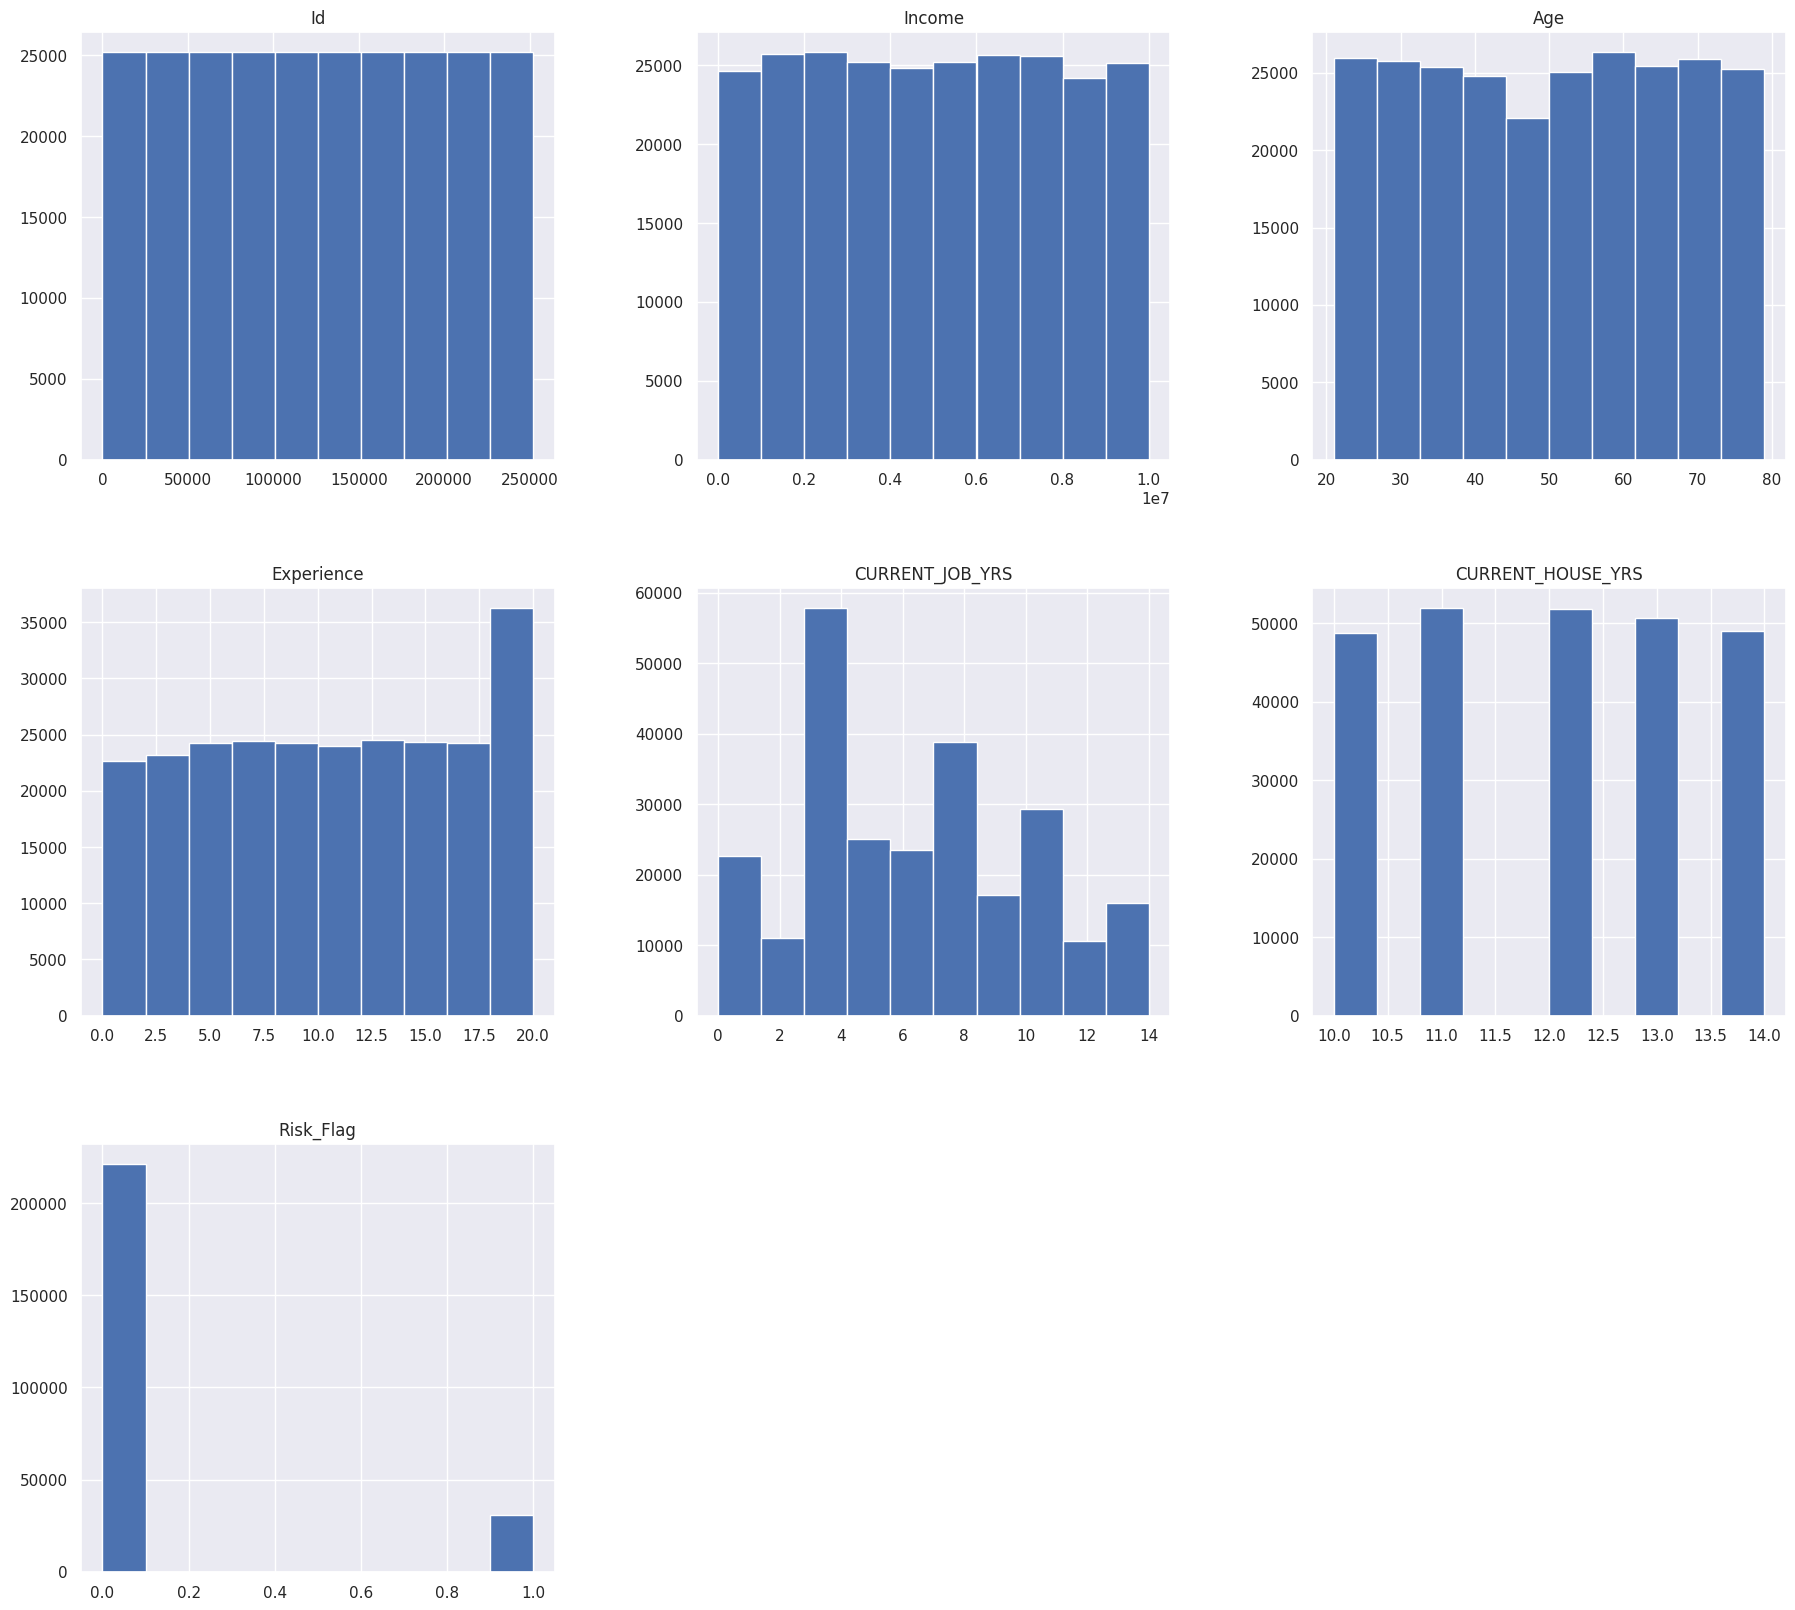

In [ ]:
df.hist( figsize = (22, 20) )
plt.show()

In [ ]:
df["Risk_Flag"].value_counts()

,count
Risk_Flag,
0,221004
1,30996


## Convert Categorical Data to Numeric

In [ ]:
df['Married/Single'].unique()

array(['single', 'married'], dtype=object)

In [ ]:
# convert Married/Single column to numeric
df['Married/Single'] = df['Married/Single'].map({'single': 0, 'married': 1})

In [ ]:
df['House_Ownership'].unique()

array(['rented', 'norent_noown', 'owned'], dtype=object)

In [ ]:
# convert Married/Single column to numeric
df['House_Ownership'] = df['House_Ownership'].map({'norent_noown': 0, 'rented': 1, 'owned': 2})

In [ ]:
df['Car_Ownership'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
# convert Married/Single column to numeric
df['Car_Ownership'] = df['Car_Ownership'].map({'no': 0, 'yes': 1})

In [ ]:
df['Profession'].unique()

array(['Mechanical_engineer', 'Software_Developer', 'Technical_writer',
       'Civil_servant', 'Librarian', 'Economist', 'Flight_attendant',
       'Architect', 'Designer', 'Physician', 'Financial_Analyst',
       'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
       'Surveyor', 'Design_Engineer', 'Chemical_engineer',
       'Hotel_Manager', 'Dentist', 'Comedian', 'Biomedical_Engineer',
       'Graphic_Designer', 'Computer_hardware_engineer',
       'Petroleum_Engineer', 'Secretary', 'Computer_operator',
       'Chartered_Accountant', 'Technician', 'Microbiologist',
       'Fashion_Designer', 'Aviator', 'Psychologist', 'Magistrate',
       'Lawyer', 'Firefighter', 'Engineer', 'Official', 'Analyst',
       'Geologist', 'Drafter', 'Statistician', 'Web_designer',
       'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
       'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
      dtype=object)

In [ ]:
df['CITY'].unique()

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar',
       'Tiruchirappalli[10]', 'Jalgaon', 'Tiruppur', 'Jamnagar',
       'Kota[6]', 'Karimnagar', 'Hajipur[31]', 'Adoni', 'Erode[17]',
       'Kollam', 'Madurai', 'Anantapuram[24]', 'Kamarhati', 'Bhusawal',
       'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad', 'Ajmer',
       'Ongole', 'Miryalaguda', 'Ambattur', 'Indore', 'Pondicherry',
       'Shimoga', 'Chennai', 'Gulbarga', 'Khammam', 'Saharanpur',
       'Gopalpur', 'Amravati', 'Udupi', 'Howrah', 'Aurangabad[39]',
       'Hospet', 'Shimla', 'Khandwa', 'Bidhannagar', 'Bellary', 'Danapur',
       'Purnia[26]', 'Bijapur', 'Patiala', 'Malda', 'Sagar', 'Durgapur',
       'Junagadh', 'Singrauli', 'Agartala', 'Thanjavur', 'Hindupur',
       'Naihati', 'North_Dumdum', 'Panchkula', 'Anantapur', 'Serampore',
       'Bathinda', 'Nadiad', 'Kanpur', 'Haridwar', 'Berhampur',
       'Jamshedpur', 'Hyderabad', 'Bidar', 'Kottayam', 'Solapur',
       'Suryapet', 'Aizawl', 'Asansol', 'Deoghar'

In [ ]:
df['STATE'].unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

In [ ]:
high_card_features = ['Profession', 'CITY', 'STATE']
count_encoder = ce.CountEncoder()

# Transform the features, rename the columns with the _count suffix, and join to dataframe
count_encoded = count_encoder.fit_transform( df[high_card_features] )
df = df.join(count_encoded.add_suffix("_count"))
df= df.drop(labels=['Profession', 'CITY', 'STATE'], axis=1)

In [ ]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Profession_count,CITY_count,STATE_count
0,1,1303834,23,3,0,1,0,3,13,0,5217,798,14122
1,2,7574516,40,10,0,1,0,9,13,0,5053,849,25562
2,3,3991815,66,4,1,1,0,4,10,0,5195,688,5805
3,4,6256451,41,2,0,1,1,2,12,1,5053,607,4658
4,5,5768871,47,11,0,1,0,3,14,1,4413,809,16537


### How is the correlation between features(other Colms) and target col?

In [ ]:
df.corr()['Risk_Flag']

,Risk_Flag
Income,-0.003091
Age,-0.021809
Experience,-0.034523
Married/Single,-0.021092
House_Ownership,-0.011171
Car_Ownership,-0.024036
CURRENT_JOB_YRS,-0.016942
CURRENT_HOUSE_YRS,-0.004375
Risk_Flag,1.000000
Profession_count,-0.008587


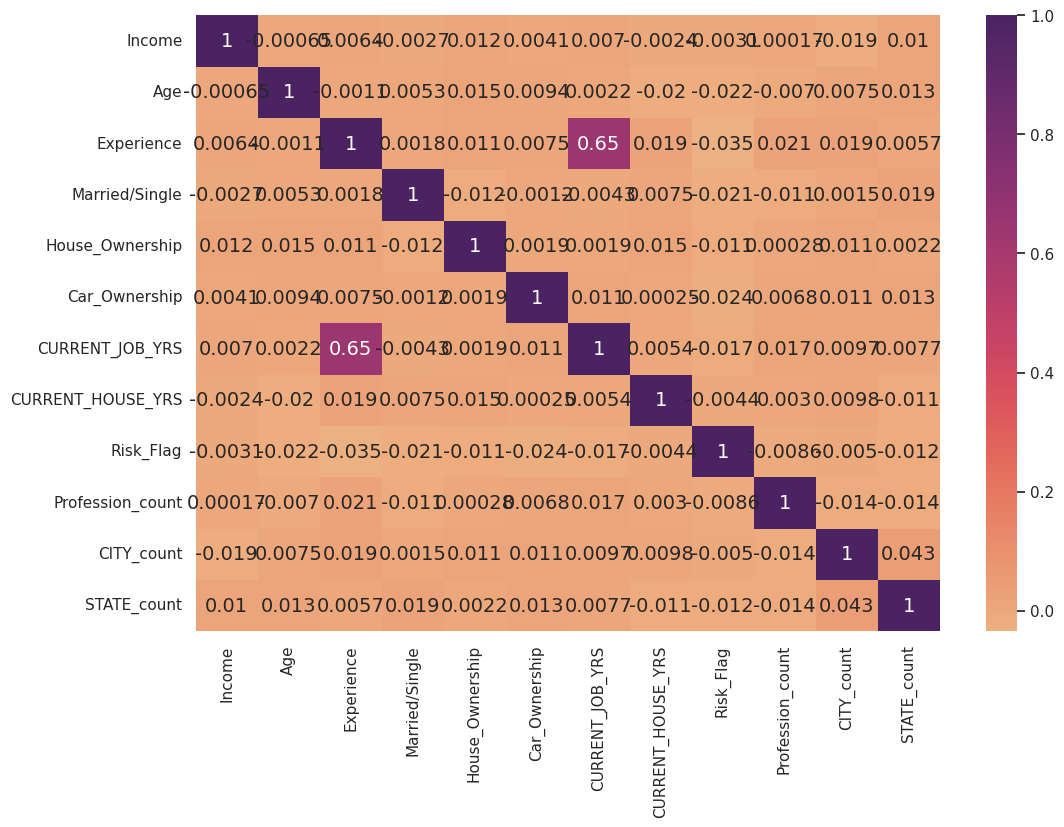

In [ ]:
fig, ax = plt.subplots( figsize = (12,8) )
corr_matrix = df.corr()
corr_heatmap = sns.heatmap( corr_matrix, cmap = "flare", annot=True, ax=ax, annot_kws={"size": 14})
plt.show()

#  Extract input and output cols and perform Train test split

In [ ]:
x = df.drop("Risk_Flag", axis=1)
y = df["Risk_Flag"]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, stratify = y,random_state = 7)

### Perform Scalling

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Train and Evaluate the model

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini', bootstrap=True, max_depth=10, max_features=None, min_samples_split=2, n_estimators=100, random_state=100)

# With Scaling
clf.fit(X_train_scale,y_train)
y_pred = clf.predict(X_test_scale)
print("With Scaling: ",accuracy_score(y_test,y_pred))

print("-------------------------TEST SCORES-----------------------")
print(f"Recall: { recall_score(y_test, y_pred) }")
print(f"Precision: { precision_score(y_test, y_pred) }")
print(f"F1-Score: { f1_score(y_test, y_pred) }")
print(f"Accuracy score: { accuracy_score(y_test, y_pred) }")
print(f"AUC Score: { roc_auc_score(y_test, y_pred) }")


With Scaling:  0.8803571428571428
-------------------------TEST SCORES-----------------------
Recall: 0.042103565091143734
Precision: 0.7393767705382436
F1-Score: 0.07967032967032966
Accuracy score: 0.8803571428571428
AUC Score: 0.5200110821089301


# Train and Evaluate the model with best parameters

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='gini', bootstrap = True, max_depth = 20, max_features = None, min_samples_split=10,n_estimators = 100, random_state=100)
# With Scaling
clf.fit(X_train_scale,y_train)
y_pred = clf.predict(X_test_scale)
print("With Scaling: ",accuracy_score(y_test,y_pred))
print("-------------------------TEST SCORES-----------------------")
print(f"Recall: { recall_score(y_test, y_pred) }")
print(f"Precision: { precision_score(y_test, y_pred) }")
print(f"F1-Score: { f1_score(y_test, y_pred) }")
print(f"Accuracy score: { accuracy_score(y_test, y_pred) }")
print(f"AUC Score: { roc_auc_score(y_test, y_pred) }")

With Scaling:  0.8971031746031746
-------------------------TEST SCORES-----------------------
Recall: 0.40554928214228103
Precision: 0.6261519302615193
F1-Score: 0.49226551791658507
Accuracy score: 0.8971031746031746
AUC Score: 0.6857953872081057


## Deploy the model

### Model Dump

In [ ]:
pickle.dump(clf,open('model.pkl','wb'))

### Load Model

In [ ]:
model = pickle.load(open('model.pkl','rb'))

### Make Predictions

In [ ]:
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Profession_count,CITY_count,STATE_count
0,1303834,23,3,0,1,0,3,13,0,5217,798,14122
1,7574516,40,10,0,1,0,9,13,0,5053,849,25562
2,3991815,66,4,1,1,0,4,10,0,5195,688,5805
3,6256451,41,2,0,1,1,2,12,1,5053,607,4658
4,5768871,47,11,0,1,0,3,14,1,4413,809,16537


from matplotlib import pyplot as plt
_df_0['Income'].plot(kind='hist', bins=20, title='Income')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Experience'].plot(kind='hist', bins=20, title='Experience')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Married/Single'].plot(kind='hist', bins=20, title='Married/Single')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Income', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Age', y='Experience', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Experience', y='Married/Single', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Married/Single', y='Car_Ownership', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['House_Ownership']
  ys = series['Income']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('House_Ownership', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('House_Ownership')
_ = plt.ylabel('Income')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['House_Ownership']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('House_Ownership', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('House_Ownership')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['House_Ownership']
  ys = series['Experience']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('House_Ownership', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('House_Ownership')
_ = plt.ylabel('Experience')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['House_Ownership']
  ys = series['Married/Single']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('House_Ownership', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('House_Ownership')
_ = plt.ylabel('Married/Single')

from matplotlib import pyplot as plt
_df_12['Income'].plot(kind='line', figsize=(8, 4), title='Income')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Experience'].plot(kind='line', figsize=(8, 4), title='Experience')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Married/Single'].plot(kind='line', figsize=(8, 4), title='Married/Single')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
Income = 7574516
Age = 40
Experience = 10
Married_Single = 0 # 0 = single, 1 = married
House_Ownership = 1
Car_Ownership = 0
CURRENT_JOB_YRS = 9
CURRENT_HOUSE_YRS = 13
Profession_count = 5052
CITY_count = 849
STATE_count = 25562

prediction = model.predict([[Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_count,CITY_count, STATE_count]])
prediction

array([0])

### The predicted flag is 0 i.e. no risk